In [1]:
# import libraries
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterio.warp import reproject
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\nDSM
created directory data\raw_data\orthomosaics
created directory data\processed_data\nDSM
created directory data\processed_data\orthomosaics
created directory data\metadata
created directory output


In [ ]:
# define paths
raw_ndsm_files = raw_data_dir / 'nDSM'
processed_ndsm_files = processed_data_dir / 'nDSM'

# process all nDSM TIFF files
for ndsm_file in raw_ndsm_files.glob('*.tif'):
    
    # read each nDSM file
    ndsm = rxr.open_rasterio(ndsm_file, band_as_variable = True)

    # assign O values as NaN to the nDSM files
    ndsm['band_1'] = ndsm['band_1'].where(ndsm['band_1'] != np.float32(-3.4e+38), 0)

    # set the _FillValue attribute
    fill_value_attrs = {'_FillValue': 0}
    ndsm['band_1'].attrs.update(fill_value_attrs)

    # save modified nDSM files to disk
    ndsm.rio.to_raster(processed_ndsm_files / ndsm_file.name)
    print(f"{ndsm_file.name} saved to disk at {processed_ndsm_files}")

In [ ]:
# before executing this:
# exclude CFB044 and CFB089 from orginial orthomosaics and nDSM

# define paths
ndsm_path = raw_data_dir / 'nDSM'
ortho_path = raw_data_dir / 'orthomosaics'
processed_ortho_files = processed_data_dir / 'orthomosaics'

# iterate over the orthomosaic files
for ortho_file in ortho_path.glob('*.tif'):
    
    # determine the corresponding nDSM file
    ndsm_file_name = 'nDSM_' + ortho_file.stem.split('_')[0] + '.tif'
    ndsm_file = ndsm_path / ndsm_file_name

    # read the nDSM and orthomosaic files
    ndsm = rxr.open_rasterio(ndsm_file, band_as_variable = True)
    ortho = rxr.open_rasterio(ortho_file, band_as_variable = True)

    # calculate downscale factors
    downscale_factor_x = ndsm.rio.width / ortho.rio.width
    downscale_factor_y = ndsm.rio.height / ortho.rio.height
    
    # calculate new heights and widths
    x_downscaled = ortho.rio.width * downscale_factor_x
    y_downscaled = ortho.rio.height * downscale_factor_y
    
    # downsample the orthomosaic
    ortho_downsampled = ortho.rio.reproject(
        ortho.rio.crs,
        shape=(int(y_downscaled), int(x_downscaled)),
        resampling=Resampling.bilinear
    )

    # remove the fourth band (no information)
    if 'band_4' in ortho_downsampled:
        
        ortho_downsampled = ortho_downsampled.drop_vars('band_4')

    # write the processed orthomosaic to disk
    ortho_downsampled.rio.to_raster(processed_ortho_files / ortho_file.name)
    print(f"{ortho_file.name} saved to disk at {processed_ortho_files}")

In [3]:
# for reading a single file

# data reading
#--------------
# define paths to already preprocessed nDSM and orthomosaic files
ndsm_path = processed_data_dir / 'nDSM'
ortho_path = processed_data_dir / 'orthomosaics'

# read one example file for both nDSM and orthomosaic
ndsm = rxr.open_rasterio(ndsm_path / 'nDSM_CFB030.tif', band_as_variable = True)
ortho = rxr.open_rasterio(ortho_path / 'CFB030_ortho.tif', band_as_variable = True)

print(ndsm)
print(ortho)

<xarray.Dataset>
Dimensions:      (x: 2600, y: 2600)
Coordinates:
  * x            (x) float64 4.01e+05 4.01e+05 4.01e+05 ... 4.011e+05 4.011e+05
  * y            (y) float64 5.281e+06 5.281e+06 ... 5.281e+06 5.281e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area
<xarray.Dataset>
Dimensions:      (x: 2600, y: 2600)
Coordinates:
  * x            (x) float64 4.01e+05 4.01e+05 4.01e+05 ... 4.011e+05 4.011e+05
  * y            (y) float64 5.281e+06 5.281e+06 ... 5.281e+06 5.281e+06
    spatial_ref  int32 0
Data variables:
    band_1       (y, x) uint8 ...
    band_2       (y, x) uint8 ...
    band_3       (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:  Area


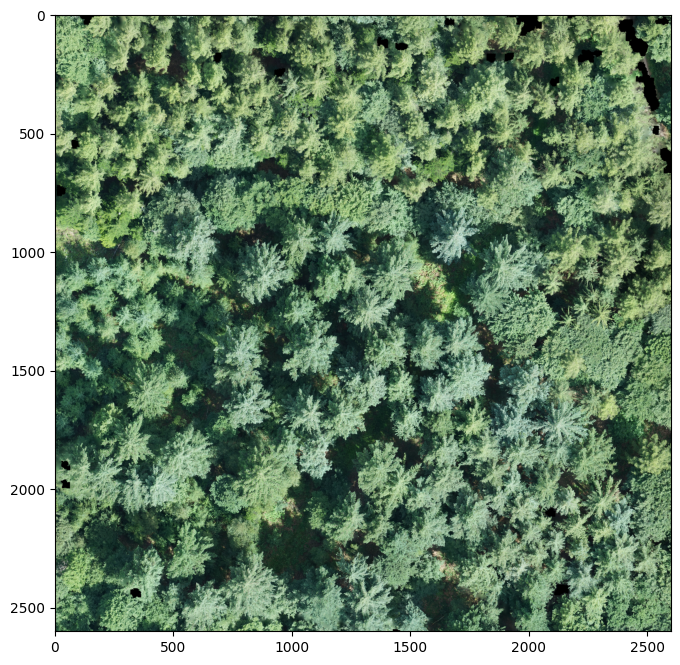

In [5]:
plt.figure(figsize=(12,8))
plt.imshow(np.array([ortho.band_1, ortho.band_2, ortho.band_3]).transpose(1,2,0))
plt.savefig(output_dir / 'example_ortho_for_report.png')

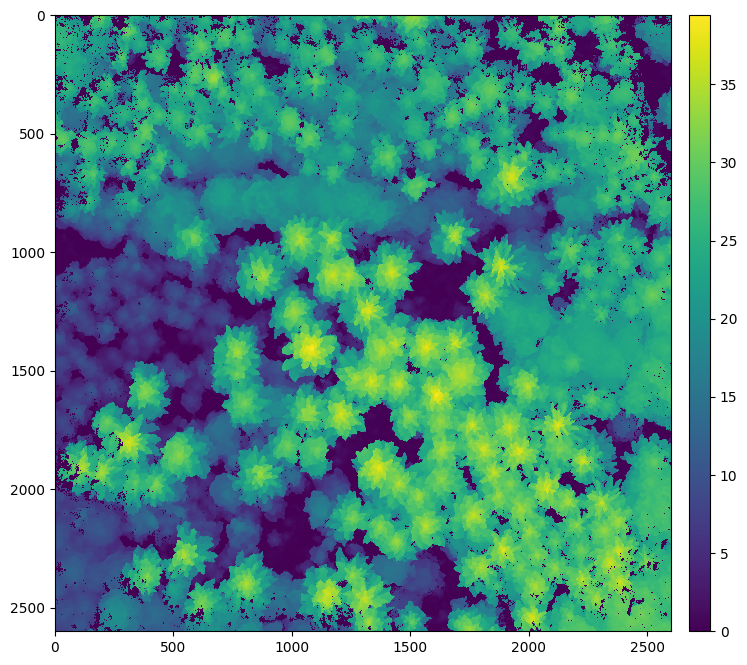

In [6]:
plt.figure(figsize=(12,8))
im = plt.imshow(ndsm['band_1'], cmap='viridis', interpolation='none')
plt.colorbar(im, aspect=30, pad = 0.02)
plt.savefig(output_dir / 'example_ndsm_for_report.png')